In [1]:
from copy import deepcopy
import datetime
import gc
import os
import pathlib
import random
import sys
sys.path.append('..')
from typing import Any, Dict, List, Tuple, Union

from joblib import dump
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OrdinalEncoder
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from scripts.dae import DAE
from scripts.get_depth_paths import get_depth_paths
from scripts.get_logger import get_logger
from scripts.merge_dataset import merge_dataset

gc.enable()

/home/ss/miniconda3/envs/home_credit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PathHandler:
    competition_dir = pathlib.Path('../../inputs')
    parquet_files_dir = competition_dir.joinpath('parquet_files')
    feature_dir = pathlib.Path('../../outputs/features')
    now_time = datetime.datetime.now()
    output_dir = pathlib.Path(
        '../../outputs/output_dae/'
        + f'model_outputs_{now_time.date()}-{now_time.hour:02}-{now_time.minute:02}'
    )
    if not output_dir.is_dir():
        output_dir.mkdir(parents=True)


paths = PathHandler()

### load cast type features

cast bool types into pl.Int8 because of NoneType and NaN.

In [3]:
bool_features = pd.read_csv(paths.feature_dir.joinpath('bool_features.csv'))
float64_features = pd.read_csv(paths.feature_dir.joinpath('float64_features.csv'))
string_features = pd.read_csv(paths.feature_dir.joinpath('string_features.csv'))
date_features = pd.read_csv(paths.feature_dir.joinpath('date_features.csv'))

bool_features['cast_dtype'] = pl.Int8
float64_features['cast_dtype'] = pl.Float32
string_features['cast_dtype'] = pl.String
date_features['cast_dtype'] = pl.Date
if paths.feature_dir.joinpath('useful_features.csv').is_file():
    useful_features = pd.read_csv(paths.feature_dir.joinpath('useful_features.csv'))
else:
    useful_features = None
#useful_features = None
display(useful_features)

None

In [4]:
train_depth_paths = get_depth_paths(paths.parquet_files_dir, 'train')
print(f'number of test paths: {sum(len(v1) for v1 in train_depth_paths.values())}')

number of test paths: 31


In [5]:
train_base_data = pl.read_parquet(
    paths.parquet_files_dir.joinpath('train/train_base.parquet')
)
train_base_data = train_base_data.cast(
    {
        'case_id': pl.Int64,
        'date_decision': pl.String,
        'MONTH': pl.Int64,
        'WEEK_NUM': pl.Int64,
        'target': pl.Int64,
    }
)
display(train_base_data)

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1
…,…,…,…,…
2703450,"""2020-10-05""",202010,91,0
2703451,"""2020-10-05""",202010,91,0
2703452,"""2020-10-05""",202010,91,0


In [6]:
%%time


depth_data = merge_dataset(
    train_base_data,
    train_depth_paths,
    bool_features,
    float64_features,
    string_features,
    date_features,
    useful_features,
    '012'
)
display(depth_data)
display(depth_data.dtypes.value_counts())

loading `static_0`
	(1003757, 168)
	(522902, 168)
loading `static_cb_0`
	(1500476, 53)
loading `applprev_1`
	(782997, 91)
	(438525, 91)
loading `other_1`
	(51109, 21)
loading `tax_registry_a_1`
	(457934, 6)
loading `tax_registry_b_1`
	(150732, 7)
loading `tax_registry_c_1`
	(482265, 6)
loading `credit_bureau_a_1`
	(335275, 240)
	(549263, 240)
	(325127, 240)
	(176608, 240)
loading `credit_bureau_b_1`
	(36500, 134)
loading `deposit_1`
	(105111, 7)
loading `person_1`
	(1526659, 43)
loading `debitcard_1`
	(111772, 14)
loading `applprev_2`
	(1221522, 4)
loading `person_2`
	(1435105, 7)
loading `credit_bureau_a_2`
	(98303, 127)
	(118481, 127)
	(23734, 127)
	(156749, 127)
	(190486, 127)
	(190313, 127)
	(231250, 127)
	(150426, 127)
	(45056, 127)
	(77457, 127)
	(103033, 127)
loading `credit_bureau_b_2`
	(36447, 26)


,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P_0,amtinstpaidbefduel24m_4187115A_0,annuity_780A_0,annuitynextmonth_57A_0,applicationcnt_361L_0,...,day_first_contractmaturitydate_151D_1,day_first_lastupdate_260D_1,day_first_contractenddate_991D_1,day_first_openingdate_313D_1,day_first_birth_259D_1,day_first_birthdate_87D_1,day_first_empl_employedfrom_271D_1,day_first_openingdate_857D_1,day_first_first_empls_employedfrom_796D_2,day_first_first_pmts_date_1107D_2
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN,NaN
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,29.0,NaN,NaN,NaN
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN,NaN
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN,NaN
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,NaN,NaN,28.0,29.0,1.0,NaN,NaN,29.0,NaN,NaN


float32    955
object      92
int8         6
int64        4
Name: count, dtype: int64

CPU times: user 17min 3s, sys: 37.7 s, total: 17min 40s
Wall time: 1min 9s


### select features

In [7]:
if len([p for p in paths.feature_dir.glob('*selected_features.csv')]) > 0:
    selected_features = pd.read_csv([p for p in paths.feature_dir.glob('*selected_features.csv')][-1])
    selected_features = selected_features['processed_Variable'].iloc[:300].to_list()
    selected_features = ['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target'] + selected_features
else:
    selected_features = depth_data.columns.to_list()

depth_data = depth_data[selected_features]
display(depth_data)

,case_id,date_decision,MONTH,WEEK_NUM,target,year_first_birth_259D_1,pmtnum_254L_0,first_sex_738L_1,price_1097A_0,first_incometype_1044T_1,...,day_firstclxcampaign_1125D_0,secondquarter_766L_0,sum_median_pmts_overdue_1140A_2,first_contractst_964M_1,median_pmtamount_36A_1,numinstlswithdpd5_4187116L_0,median_instlamount_852A_1,day_first_empl_employedfrom_271D_1,sum_nominalrate_281L_1,month_first_dateofrealrepmt_138D_1
0,0,2019-01-03,201901,0,0,1986.0,24.0,F,NaN,SALARIED_GOVT,...,NaN,NaN,NaN,None,NaN,NaN,NaN,15.0,NaN,NaN
1,1,2019-01-03,201901,0,0,1957.0,18.0,M,NaN,SALARIED_GOVT,...,NaN,NaN,NaN,None,NaN,NaN,NaN,29.0,NaN,NaN
2,2,2019-01-04,201901,0,0,1974.0,36.0,F,NaN,EMPLOYED,...,NaN,NaN,NaN,None,NaN,NaN,NaN,15.0,NaN,NaN
3,3,2019-01-03,201901,0,0,1993.0,12.0,F,NaN,EMPLOYED,...,NaN,NaN,NaN,None,NaN,NaN,NaN,15.0,NaN,NaN
4,4,2019-01-04,201901,0,1,1994.0,24.0,F,NaN,EMPLOYED,...,NaN,NaN,NaN,None,NaN,NaN,NaN,15.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,1960.0,12.0,F,0.0,RETIRED_PENSIONER,...,9.0,1.0,0.0,7241344e,NaN,1.0,370.800018,NaN,42.000000,7.0
1526655,2703451,2020-10-05,202010,91,0,1950.0,24.0,F,NaN,RETIRED_PENSIONER,...,1.0,1.0,0.0,7241344e,NaN,0.0,NaN,NaN,26.900000,12.0
1526656,2703452,2020-10-05,202010,91,0,1977.0,11.0,M,0.0,PRIVATE_SECTOR_EMPLOYEE,...,NaN,0.0,0.0,7241344e,NaN,0.0,420.000000,NaN,0.000000,9.0
1526657,2703453,2020-10-05,202010,91,0,1950.0,6.0,F,0.0,RETIRED_PENSIONER,...,21.0,2.0,0.0,7241344e,NaN,9.0,0.000000,NaN,42.000000,6.0


In [8]:
def encode_objects(
        depth_data: pd.DataFrame,
        output_dir: pathlib.Path
    ) -> pd.DataFrame:

    if not output_dir.is_dir():
        output_dir.mkdir(parents=True)

    object_columns = depth_data.dtypes.index[depth_data.dtypes==object].to_list()
    if 'date_decision' in object_columns:
        object_columns.remove('date_decision')
    print(len(object_columns))
    
    object_data = []
    for col in object_columns:
        encoder = OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=-1,
            encoded_missing_value=-1,
            dtype=np.int32,
        )
        encoded_class = encoder.fit_transform(depth_data[col].values.reshape(-1, 1))
        object_data.append(encoded_class)
        dump(encoder, output_dir.joinpath(f'encoder_{col}.joblib'))
    depth_data.drop(columns=object_columns, inplace=True)
    object_data = np.concatenate(object_data, axis=1)
    object_data = pd.DataFrame(object_data, columns=object_columns)
    
    return pd.concat([depth_data, object_data], axis=1), object_columns

In [9]:
%%time


depth_data, categorical_features = encode_objects(
    depth_data,
    paths.output_dir.joinpath('encoders')
)
display(depth_data)

#categorical_features += [col for col in depth_data.columns if col.startswith('year_') or col.startswith('month_') or col.startswith('day_')]
print(len(categorical_features))

30


,case_id,date_decision,MONTH,WEEK_NUM,target,year_first_birth_259D_1,pmtnum_254L_0,price_1097A_0,mobilephncnt_593L_0,median_dpdmaxdateyear_596T_1,...,first_registaddr_district_1083M_1,lastapprcommoditycat_1041M_0,lastrejectreasonclient_4145040M_0,previouscontdistrict_112M_0,first_language1_981M_1,disbursementtype_67L_0,first_education_1138M_1,first_district_544M_1,first_rejectreasonclient_4145042M_1,first_contractst_964M_1
0,0,2019-01-03,201901,0,0,1986.0,24.0,NaN,1.0,NaN,...,926,44,13,222,0,1,6,969,14,198
1,1,2019-01-03,201901,0,0,1957.0,18.0,NaN,1.0,NaN,...,16,44,13,222,0,1,6,969,14,198
2,2,2019-01-04,201901,0,0,1974.0,36.0,NaN,2.0,NaN,...,946,44,13,222,0,1,4,187,13,198
3,3,2019-01-03,201901,0,0,1993.0,12.0,NaN,1.0,NaN,...,292,44,13,222,0,1,4,170,13,198
4,4,2019-01-04,201901,0,1,1994.0,24.0,NaN,1.0,NaN,...,495,44,13,222,0,1,5,477,13,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,1960.0,12.0,0.0,3.0,2019.0,...,140,8,12,32,1,1,5,136,13,72
1526655,2703451,2020-10-05,202010,91,0,1950.0,24.0,NaN,2.0,2019.0,...,331,44,13,73,1,1,5,322,13,72
1526656,2703452,2020-10-05,202010,91,0,1977.0,11.0,0.0,1.0,2019.0,...,516,17,13,40,1,1,5,178,13,72
1526657,2703453,2020-10-05,202010,91,0,1950.0,6.0,0.0,2.0,2020.0,...,143,44,13,33,1,1,5,138,13,72


30
CPU times: user 3.62 s, sys: 473 ms, total: 4.1 s
Wall time: 4.08 s


In [10]:
display(depth_data[categorical_features].nunique().sort_values())
display(depth_data[categorical_features].isna().sum().sort_values())

first_sex_738L_1                         2
first_language1_981M_1                   3
description_5085714M_0                   3
disbursementtype_67L_0                   4
first_education_927M_1                   6
education_88M_0                          6
education_1103M_0                        6
first_familystate_447L_1                 6
maritalst_893M_0                         7
first_education_1138M_1                  7
maritalst_385M_0                         7
first_incometype_1044T_1                 9
first_description_351M_1                12
lastrejectreasonclient_4145040M_0       14
first_rejectreasonclient_4145042M_1     15
riskassesment_302T_0                    18
lastrejectreason_759M_0                 18
first_rejectreason_755M_1               19
lastapprcommoditycat_1041M_0            45
lastcancelreason_561M_0                 74
first_cancelreason_3545846M_1           75
first_financialinstitution_591M_1      182
first_contractst_964M_1                199
previouscon

first_sex_738L_1                       0
first_district_544M_1                  0
first_education_1138M_1                0
disbursementtype_67L_0                 0
first_language1_981M_1                 0
previouscontdistrict_112M_0            0
lastrejectreasonclient_4145040M_0      0
lastapprcommoditycat_1041M_0           0
first_registaddr_district_1083M_1      0
lastcancelreason_561M_0                0
first_description_351M_1               0
first_financialinstitution_591M_1      0
first_classificationofcontr_400M_1     0
first_rejectreason_755M_1              0
first_empladdr_district_926M_1         0
first_contaddr_district_15M_1          0
first_cancelreason_3545846M_1          0
first_familystate_447L_1               0
description_5085714M_0                 0
lastrejectreason_759M_0                0
education_1103M_0                      0
education_88M_0                        0
first_financialinstitution_382M_1      0
first_education_927M_1                 0
maritalst_893M_0

In [11]:
class CFG:
    def __init__(
            self,
            outputs_dir: pathlib.Path,
            n_splits: int = 5,
            seed: int = 42,
            epochs: int = 5,
            batch_size: int = 128,
            learning_rate: float = 1e-03,
            accumulation_step: int = 1,
            patience: int = 5,
            swap_noise_probability: float = 0.1,
            debag: bool = False,
        ) -> None:
        
        self.outputs_dir = outputs_dir
        self.n_splits = n_splits
        self.seed = seed
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.accumulation_step = accumulation_step
        self.debag = debag
        self.patience = patience
        self.swap_noise_probability = swap_noise_probability
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def seed_everything(self) -> None:
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)  
        os.environ['PYTHONHASHSEED'] = str(self.seed)

    def seed_generator(self) -> object:
        g = torch.Generator()
        g.manual_seed(self.seed)
        return g

In [12]:
class DAE(nn.Module):
    def __init__(
            self,
            num_continuous: int,
            num_categorical: int
        ) -> None:
        
        super().__init__()
        self.continuous_emb = nn.ModuleList()
        for _ in range(num_continuous):
            self.continuous_emb.append(
                nn.Sequential(
                    nn.Linear(1, 8),
                    nn.ReLU(),
                )
            )

        self.cate_emb = nn.Sequential(
            nn.Embedding(1000, 8),
            nn.ReLU(),
        )
        self.backbone = nn.Sequential(
            nn.Linear(num_continuous*8+num_categorical*8, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_continuous+num_categorical),
        )

        self.mask_regressor = nn.Sequential(
            nn.Linear(num_continuous*8+num_categorical*8, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_continuous+num_categorical),
        )

    def forward(
            self,
            x_cont: torch.Tensor,
            x_cate: torch.Tensor
        ) -> torch.Tensor:
        
        z_cont = torch.cat(
            [
                self.continuous_emb[i](x_cont[:, [i]].to(torch.float32))
                for i in range(x_cont.shape[1])
            ],
            dim=1,
        )
        z_cate = self.cate_emb(x_cate)
        z_cate = z_cate.flatten(start_dim=1)
        z = torch.cat([z_cont, z_cate], dim=1)
        logit = self.backbone(z)
        mask = self.mask_regressor(z)
        return logit, mask

In [13]:
class MyDataset(Dataset):
    def __init__(
            self,
            continuous_X: pd.DataFrame,
            categorical_X: pd.DataFrame,
            swap_noise_probability: float,
        ) -> None:
        
        self.cont_X = torch.from_numpy(continuous_X.values).float()
        self.cate_X = torch.from_numpy(categorical_X.values).int()
        self.swap_noise_probability = swap_noise_probability

    def __len__(self) -> int:
        return len(self.cont_X)
    
    def __getitem__(
            self,
            index: int
        ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        
        return self.cont_X[index], self.cate_X[index]
    
    def _standardize(self, x: np.ndarray) -> np.ndarray:
        column_mean = np.nanmean(x, axis=0, keepdims=True)
        column_std = np.nanstd(x, axis=0, keepdims=True)
        x = (x - column_mean) / (column_std + 1e-06)
        return x

In [14]:
def build_dataloader(
        continuous_X: pd.DataFrame,
        categorical_X: pd.DataFrame,
        swap_noise_probability: float,
        batch_size: int,
        shuffle: bool,
        generator: object,
    ) -> object:
    
    dataset = MyDataset(
        continuous_X=continuous_X,
        categorical_X=categorical_X,
        swap_noise_probability=swap_noise_probability,
    )
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=False,
        worker_init_fn=seed_worker,
        generator=generator,
        num_workers=os.cpu_count()//2,
        pin_memory=True,
    )

    del dataset
    
    return dataloader


def seed_worker(worker_id: int) -> None:
    # copied from https://pytorch.org/docs/stable/notes/randomness.html
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def swap_noise(x: torch.Tensor, swap_noise_probability: float):
    is_swap = torch.bernoulli(swap_noise_probability * torch.ones_like(x).to(x.device))
    swaped_x = torch.where(is_swap==1, x.reshape(-1)[torch.randperm(x.numel())].reshape(x.size()), x)
    mask = (x != swaped_x).float()
    return swaped_x, mask

In [15]:
def train(
        dataloader: object,
        model: object,
        loss_fn1: object,
        loss_fn2: object,
        optimizer: object,
        scheduler: object,
        device: object,
        accumulation_step: int = 1,
        swap_noise_probability: float = 0.4,
    ) -> None:
    
    model.train()
    for i, (x_cont, x_cate) in enumerate(dataloader):
        x_cont = x_cont.to(device) # (N, C)
        x_cate = x_cate.to(device) # (N, C)

        noisy_x_cont, m_cont = swap_noise(x_cont, swap_noise_probability)
        noisy_x_cate, m_cate = swap_noise(x_cate, swap_noise_probability)

        y = torch.cat([x_cont, x_cate], dim=1)
        m = torch.cat([m_cont, m_cate], dim=1)

        y_hat, m_hat = model(noisy_x_cont, noisy_x_cate)
        loss = loss_fn1(y_hat, y) + loss_fn2(m_hat, m)
        loss /= accumulation_step
        
        loss.backward()

        if (i + 1) % accumulation_step == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        del x_cont, x_cate, noisy_x_cont, noisy_x_cate
        del y, m, y_hat, m_hat
        gc.collect()
        torch.cuda.empty_cache()
        
    scheduler.step()


def test(
        dataloader: object,
        model: object,
        device: object,
        swap_noise_probability: float = 0.4,
    ) -> Tuple[float, torch.Tensor]:
    
    model.eval()

    loss1 = -999 * torch.ones(len(dataloader.dataset))
    loss2 = -999 * torch.ones(len(dataloader.dataset))
    cossim = -999 * torch.ones(len(dataloader.dataset))

    start = 0
    with torch.no_grad():
        for i, (x_cont, x_cate) in enumerate(dataloader):

            x_cont = x_cont.to(device) # (N, C)
            x_cate = x_cate.to(device) # (N, C)

            noisy_x_cont, m_cont = swap_noise(x_cont, swap_noise_probability)
            noisy_x_cate, m_cate = swap_noise(x_cate, swap_noise_probability)

            y = torch.cat([x_cont, x_cate], dim=1)
            m = torch.cat([m_cont, m_cate], dim=1)
            
            y_hat, m_hat = model(noisy_x_cont, noisy_x_cate)

            loss1[start: start+len(y)] = torch.mean((y_hat - y)**2, dim=1)
            loss2[start: start+len(y)] = torch.mean(
                nn.functional.binary_cross_entropy_with_logits(m_hat, m, reduction='none'),
                dim=1
            )
            cossim[start: start+len(y)] = nn.functional.cosine_similarity(y_hat, y, dim=1)
            start += len(y)

        del x_cont, x_cate, noisy_x_cont, noisy_x_cate
        del y, m, y_hat, m_hat
        gc.collect()
        torch.cuda.empty_cache()

    loss = loss1.mean().item() + loss2.mean().item()
    loss1 = loss1.to('cpu').detach().numpy()
    loss2 = loss2.to('cpu').detach().numpy()
    
    return loss, loss1, loss2, cossim


def test_best_model(
        dataloader: object,
        model: object,
        device: object,
        swap_noise_probability: float = 0.4,
    ) -> Tuple[float, torch.Tensor]:
    
    model.eval()

    # loss1 = -999 * torch.ones(len(dataloader.dataset))
    # loss2 = -999 * torch.ones(len(dataloader.dataset))
    # cossim = -999 * torch.ones(len(dataloader.dataset))

    start = 0
    X_pred = []
    mask_truth = []
    mask_pred = []
    with torch.no_grad():
        for x_cont, x_cate in dataloader:

            x_cont = x_cont.to(device) # (N, C)
            x_cate = x_cate.to(device) # (N, C)

            noisy_x_cont, m_cont = swap_noise(x_cont, swap_noise_probability)
            noisy_x_cate, m_cate = swap_noise(x_cate, swap_noise_probability)

            y = torch.cat([x_cont, x_cate], dim=1)
            m = torch.cat([m_cont, m_cate], dim=1)
            
            y_hat, m_hat = model(noisy_x_cont, noisy_x_cate)

            # loss1[start: start+len(y)] = torch.mean((y_hat - y)**2, dim=1)
            # loss2[start: start+len(y)] = torch.mean((m_hat - m)**2, dim=1)
            # cossim[start: start+len(y)] = nn.functional.cosine_similarity(y_hat, y, dim=1)
            # start += len(y)

            X_pred.append(y_hat.to('cpu').detach().numpy())
            mask_truth.append(m.to('cpu').detach().numpy())
            mask_pred.append((m_hat.sigmoid() > 0.5).float().to('cpu').detach().numpy())

        del x_cont, x_cate, y, m
        del y_hat, m_hat
        gc.collect()
        torch.cuda.empty_cache()

    # loss = loss1.mean().item() + loss2.mean().item()
    # loss1 = loss1.to('cpu').detach().numpy()
    # loss2 = loss2.to('cpu').detach().numpy()

    X_pred = np.concatenate(X_pred)
    mask_truth = np.concatenate(mask_truth)
    mask_pred = np.concatenate(mask_pred)
    
    return X_pred, mask_truth, mask_pred

In [16]:
def train_using_cv(
        config: Dict[str, Any],
        logger: object,
        X: pd.DataFrame,
        categorical_features: List[str],
    ) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, pd.DataFrame]]:
    
    kfold = GroupKFold(
        n_splits=config.n_splits,
    )
    
    history = {}
    models = []

    weeks = X[['WEEK_NUM']].copy()
    oof = X[['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target']].copy()
    oof_losses = -999 * np.ones((len(oof), 3))
    folds = -1 * np.ones(len(oof))

    X.drop(columns=['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target'], inplace=True)
    display(X.dtypes.value_counts())
    display(oof)

    continuous_X = X[[col for col in X.columns if col not in categorical_features]]
    categorical_X = X[categorical_features]

    del X
    gc.collect()

    X_preds = np.zeros((len(continuous_X), continuous_X.shape[1]+categorical_X.shape[1]))
    mask_truths = np.zeros((len(continuous_X), continuous_X.shape[1]+categorical_X.shape[1]))
    mask_preds = np.zeros((len(continuous_X), continuous_X.shape[1]+categorical_X.shape[1]))

    '''
    standardize
    '''
    column_mean = np.nanmean(continuous_X, axis=0, keepdims=True)
    column_std = np.nanstd(continuous_X, axis=0, keepdims=True)
    continuous_X = (continuous_X - column_mean) / (column_std + 1e-06)
    continuous_X.fillna(0, inplace=True)
    categorical_X.fillna(-1, inplace=True)

    logger.info(f'number of continuous features: {continuous_X.shape}')
    logger.info(f'number of categorical features: {categorical_X.shape}')
    
    np.save(config.outputs_dir.joinpath('training_continuous_features.npy'), continuous_X.columns.to_numpy())
    np.save(config.outputs_dir.joinpath('training_categorical_features.npy'), categorical_X.columns.to_numpy())
    
    best_epoch = 0
    
    logger.info('start training...')
    
    for k, (train_indices, valid_indices) in enumerate(kfold.split(X=continuous_X, groups=weeks)):

        logger.info(f'fold: {k+1}')
        logger.info(f'# of train: {len(train_indices)}')
        logger.info(f'# of valid: {len(valid_indices)}')

        logger.info(f'train WEEK_NUM: {oof.iloc[train_indices]["WEEK_NUM"].unique()}')
        logger.info(f'valid WEEK_NUM: {oof.iloc[valid_indices]["WEEK_NUM"].unique()}')
        
        train_cont_X = continuous_X.iloc[train_indices]
        train_cate_X = categorical_X.iloc[train_indices]

        valid_cont_X = continuous_X.iloc[valid_indices]
        valid_cate_X = categorical_X.iloc[valid_indices]
        
        generator = torch.Generator()
        generator.manual_seed(config.seed)

        train_dataloader = build_dataloader(
            continuous_X=train_cont_X,
            categorical_X=train_cate_X,
            swap_noise_probability=config.swap_noise_probability,
            batch_size=config.batch_size,
            shuffle=True,
            generator=generator,
        )
        valid_dataloader = build_dataloader(
            continuous_X=valid_cont_X,
            categorical_X=valid_cate_X,
            swap_noise_probability=config.swap_noise_probability,
            batch_size=2*config.batch_size,
            shuffle=False,
            generator=generator,
        )
        
        model = DAE(
            num_continuous=continuous_X.shape[1],
            num_categorical=categorical_X.shape[1],
        )
        model = model.to(config.device)
        
        num_devices = torch.cuda.device_count()
        logger.info(f'number of devices: {num_devices}')
        
        if num_devices > 1:
            model = nn.DataParallel(model)
            config.learning_rate *= num_devices
            config.batch_size *= num_devices
            logger.info(f'the learning_rate changed to {config.learning_rate}.')
            logger.info(f'the batch_size changed to {config.batch_size}.')
            
        loss_fn1 = nn.MSELoss()
        loss_fn2 = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(
            [
                {'params': model.parameters()},
            ],
            lr=config.learning_rate,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=5,
            T_mult=1,
            eta_min=1e-06,
        )
        
        history[f'fold{k+1}'] = {
            'loss': [],
            'lr': [],
        }

        best_loss = np.inf
        best_cossim = torch.zeros(3)
        early_stopping_count = 0
        
        for e in tqdm(range(config.epochs)):
            
            best_epoch += 1

            lr = optimizer.param_groups[0]['lr']

            train(
                dataloader=train_dataloader,
                model=model,
                loss_fn1=loss_fn1,
                loss_fn2=loss_fn2,
                optimizer=optimizer,
                scheduler=scheduler,
                device=config.device,
                accumulation_step=config.accumulation_step,
            )
            
            if e % 5 == 0:
                train_loss, _, _, train_cossim = test(
                    dataloader=train_dataloader,
                    model=model,
                    device=config.device,
                )
            else:
                train_loss = np.nan
                train_cossim = torch.zeros(3)
            
            valid_loss, valid_loss1, valid_loss2, valid_cossim = test(
                dataloader=valid_dataloader,
                model=model,
                device=config.device,
            )
            
            if valid_loss == np.nan or valid_loss == np.inf:
                break
                
            history[f'fold{k+1}']['loss'].append(
                pd.DataFrame({'train': train_loss, 'valid': valid_loss}, index=[e])
            )
            history[f'fold{k+1}']['lr'].append(
                pd.DataFrame({'lr': lr}, index=[e])
            )
            
            if valid_cossim.mean().item() >= best_cossim.mean().item():
                best_model = deepcopy(model).to('cpu')
                best_loss = valid_loss
                best_cossim = valid_cossim
                oof_losses[valid_indices, 0] = valid_loss1
                oof_losses[valid_indices, 1] = valid_loss2
                oof_losses[valid_indices, 2] = valid_cossim
                early_stopping_count = 0
            else:
                early_stopping_count += 1

            logger.info(
                '-------------------------------------------\n'
                f'fold: {k+1}\n'
                f'epoch: {e+1}/{config.epochs}\n'
                f'current lr0 = {lr:.4e}\n'
                f'ealry stopping count = {early_stopping_count}/{config.patience}\n'
                f'train | loss   = {train_loss:.4f}\n'
                f'      | cossim = {train_cossim.mean().item():.4f}\n'
                '-------------------------------------------\n'
                f'valid | loss   = {valid_loss:.4f}\n'
                f'      | cossim = {valid_cossim.mean().item():.4f}\n'
                '-------------------------------------------\n'
                f'best  | loss   = {best_loss:.4f}\n'
                f'      | cossim = {best_cossim.mean().item():.4f}\n'
                '-------------------------------------------\n'
            )
            
            if early_stopping_count == config.patience:
                logger.info(f'Ealry Stoppped at {e+1} epoch.')
                break
                
        if best_cossim.mean().item() == 0:
            best_model = deepcopy(model).to('cpu')
            oof_losses[valid_indices, 0] = valid_loss1
            oof_losses[valid_indices, 1] = valid_loss2

        date = ''.join(config.outputs_dir.stem.split('-')[-4:])
        torch.save(
            best_model.state_dict(),
            config.outputs_dir.joinpath(f'mlp_fold{k+1}_{date}.pt'),
        )
        
        folds[valid_indices] = k
                    
        logger.info(f'best loss = {best_loss:.4f}\n')
        
        history[f'fold{k+1}']['loss'] = pd.concat(history[f'fold{k+1}']['loss'])
        history[f'fold{k+1}']['lr'] = pd.concat(history[f'fold{k+1}']['lr'])
        
        X_pred, mask_truth, mask_pred = test_best_model(
            dataloader=valid_dataloader,
            model=best_model.to(config.device),
            device=config.device,
        )
        models.append(best_model.to('cpu'))

        X_preds[valid_indices] = X_pred
        mask_truths[valid_indices] = mask_truth
        mask_preds[valid_indices] = mask_pred
        
        del train_cont_X, train_cate_X, valid_cont_X, valid_cate_X
        del train_dataloader, valid_dataloader
        del model
        del X_pred, mask_truth, mask_pred
        gc.collect()
        torch.cuda.empty_cache()
        
    best_epoch /= config.n_splits
    
    oof.loc[:, ['loss1', 'loss2', 'cossim']] = oof_losses
    oof.loc[:, 'fold'] = folds

    X_preds = pd.DataFrame(
        X_preds,
        columns=continuous_X.columns.to_list()+categorical_X.columns.to_list()
    )
    mask_truths = pd.DataFrame(
        mask_truths,
        columns=continuous_X.columns.to_list()+categorical_X.columns.to_list()
    )
    mask_preds = pd.DataFrame(
        mask_preds,
        columns=continuous_X.columns.to_list()+categorical_X.columns.to_list()
    )
    
    del oof_losses, folds
    gc.collect()
    torch.cuda.empty_cache()

    logger.info('Done!\n')
    
    return oof, history, X_preds, mask_truths, mask_preds

In [17]:
%%time


config = CFG(
    outputs_dir=paths.output_dir,
    n_splits=5,
    epochs=10,
    batch_size=2048,
    learning_rate=1e-03,
    patience=5,
    swap_noise_probability=0.4,
    debag=False,
)
config.seed_everything()

logger = get_logger(paths.output_dir.joinpath('output.log'))

log = [
    f'{k} = {config.__dict__[k]}'
    for k, v in config.__dict__.items()
    if not k.startswith('__')
]
logger.info('\n'.join(log))
logger.info('\n')

depth_data = depth_data.query('target==0').reset_index(drop=True)

if config.debag:
    depth_data = depth_data.sample(n=10000, random_state=config.seed)
    depth_data = depth_data.reset_index(drop=True)
    
oof, history, X_preds, mask_truth, mask_preds = train_using_cv(config, logger, depth_data, categorical_features)

2024-05-13 19:44:41,094 scripts.get_logger:20 <module> [INFO]:
outputs_dir = ../../outputs/output_dae/model_outputs_2024-05-13-19-43
n_splits = 5
seed = 42
epochs = 10
batch_size = 2048
learning_rate = 0.001
accumulation_step = 1
debag = False
patience = 5
swap_noise_probability = 0.4
device = cuda
2024-05-13 19:44:41,095 scripts.get_logger:21 <module> [INFO]:




float32    269
int32       30
int8         1
Name: count, dtype: int64

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,5,2019-01-02,201901,0,0
...,...,...,...,...,...
1478660,2703450,2020-10-05,202010,91,0
1478661,2703451,2020-10-05,202010,91,0
1478662,2703452,2020-10-05,202010,91,0
1478663,2703453,2020-10-05,202010,91,0


/tmp/ipykernel_31605/2677219398.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_X.fillna(-1, inplace=True)
2024-05-13 19:44:47,562 scripts.get_logger:43 train_using_cv [INFO]:
number of continuous features: (1478665, 270)
2024-05-13 19:44:47,562 scripts.get_logger:44 train_using_cv [INFO]:
number of categorical features: (1478665, 30)
2024-05-13 19:44:47,563 scripts.get_logger:51 train_using_cv [INFO]:
start training...
2024-05-13 19:44:47,596 scripts.get_logger:55 train_using_cv [INFO]:
fold: 1
2024-05-13 19:44:47,597 scripts.get_logger:56 train_using_cv [INFO]:
# of train: 1183137
2024-05-13 19:44:47,598 scripts.get_logger:57 train_using_cv [INFO]:
# of valid: 295528
2024-05-13 19:44:47,617 scripts.get_logger:59 train_using_cv [INFO]:
train WEEK_NUM: [ 0  1  2  3  4  6  7  8  9 13 15

CPU times: user 1h 26min 16s, sys: 4min 38s, total: 1h 30min 55s
Wall time: 1h 32min 57s


,case_id,date_decision,MONTH,WEEK_NUM,target,loss1,loss2,cossim,fold
0,0,2019-01-03,201901,0,0,251.549332,0.399494,0.991175,2.0
1,1,2019-01-03,201901,0,0,1148.490234,0.382561,0.896245,2.0
2,2,2019-01-04,201901,0,0,331.769928,0.388150,0.977089,2.0
3,3,2019-01-03,201901,0,0,248.294205,0.424298,0.945493,2.0
4,5,2019-01-02,201901,0,0,37.931454,0.417208,0.998449,2.0
...,...,...,...,...,...,...,...,...,...
1478660,2703450,2020-10-05,202010,91,0,12.309123,0.452932,0.991421,1.0
1478661,2703451,2020-10-05,202010,91,0,16.000114,0.561419,0.997947,1.0
1478662,2703452,2020-10-05,202010,91,0,404.664978,0.541510,0.900352,1.0
1478663,2703453,2020-10-05,202010,91,0,21.083990,0.511042,0.985262,1.0


count    1.478665e+06
mean     1.916594e+02
std      4.336729e+02
min      1.430790e-01
25%      1.227293e+01
50%      3.843872e+01
75%      1.426697e+02
max      7.174736e+04
Name: loss1, dtype: float64


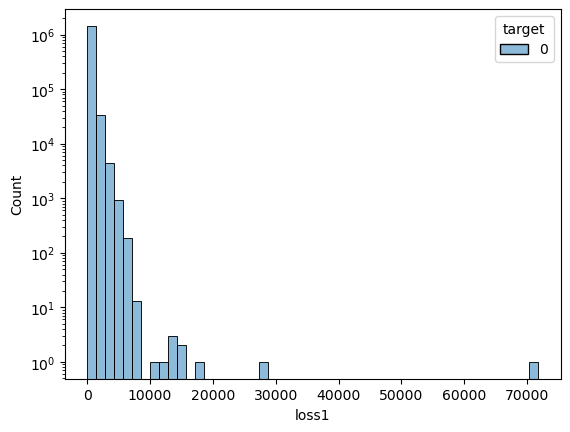

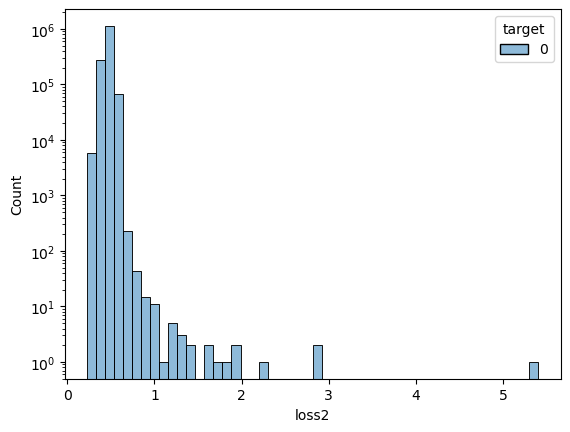

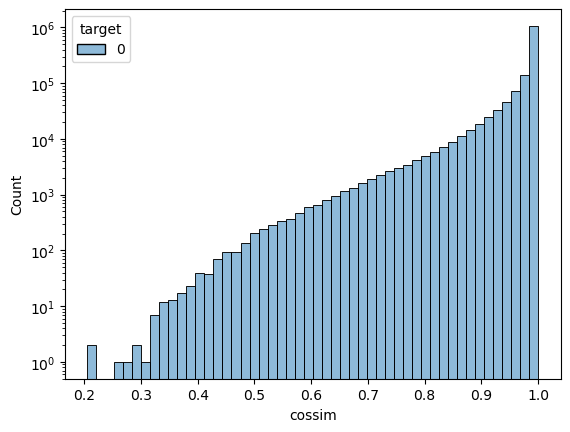

In [18]:
display(oof)
print(oof.query('loss1 != -999 & loss2 != -999')['loss1'].describe())

_, ax = plt.subplots()
sns.histplot(
    data=oof.query('loss1 != -999 & loss2 != -999'),
    x='loss1',
    hue='target',
    bins=50,
    ax=ax
)
plt.yscale('log')
plt.show()

_, ax = plt.subplots()
sns.histplot(
    data=oof.query('loss1 != -999 & loss2 != -999'),
    x='loss2',
    hue='target',
    bins=50,
    ax=ax
)
plt.yscale('log')
plt.show()

_, ax = plt.subplots()
sns.histplot(
    data=oof.query('loss1 != -999 & loss2 != -999'),
    x='cossim',
    hue='target',
    bins=50,
    ax=ax
)
plt.yscale('log')
plt.show()

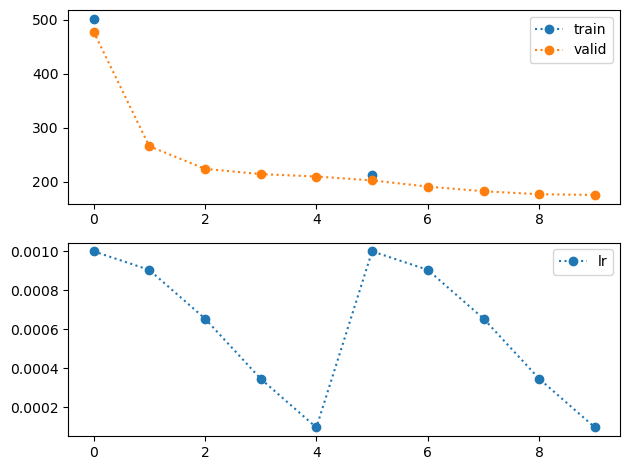

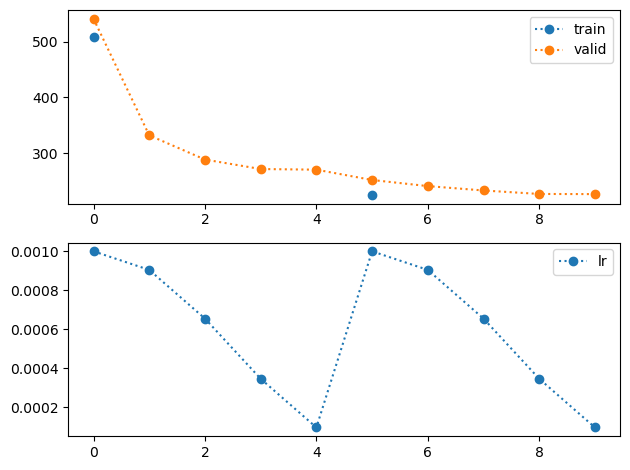

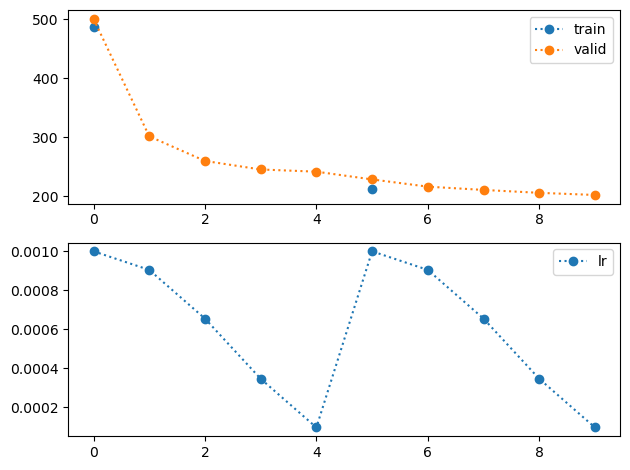

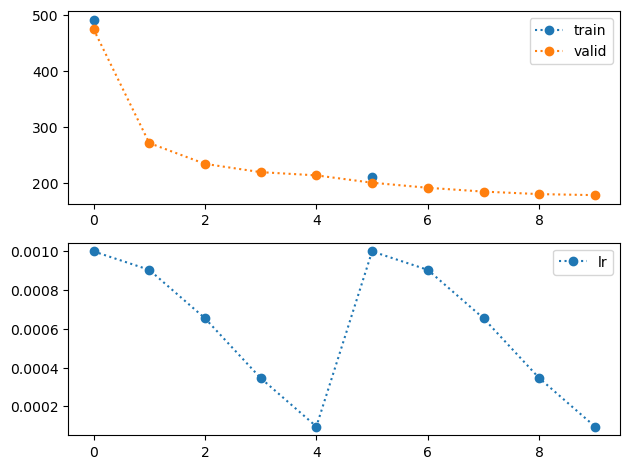

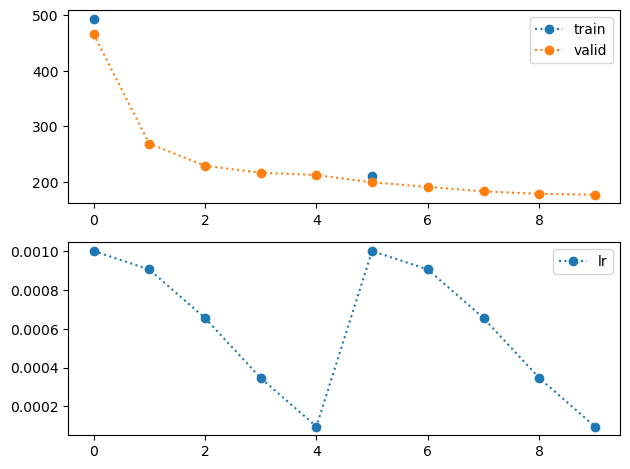

In [19]:
for k in history.keys():
    _, axs = plt.subplots(2, 1)
    history[k]['loss'].plot(marker='o', linestyle=':', ax=axs[0])
    history[k]['lr'].plot(marker='o', linestyle=':', ax=axs[1])
    plt.tight_layout()
    plt.show()

In [20]:
oof.to_csv(paths.output_dir.joinpath('oof.csv'), index=False)

In [21]:
X = depth_data[X_preds.columns]
column_mean = np.nanmean(X, axis=0, keepdims=True)
column_std = np.nanstd(X, axis=0, keepdims=True)
X = (X - column_mean) / (column_std + 1e-06)
X.fillna(0, inplace=True)

display(X)

,year_first_birth_259D_1,pmtnum_254L_0,price_1097A_0,mobilephncnt_593L_0,median_dpdmaxdateyear_596T_1,isbidproduct_1095L_0,median_maxdpdtolerance_577P_1,avgdpdtolclosure24_3658938P_0,max_totalamount_6A_1,year_first_empl_employedfrom_271D_1,...,first_registaddr_district_1083M_1,lastapprcommoditycat_1041M_0,lastrejectreasonclient_4145040M_0,previouscontdistrict_112M_0,first_language1_981M_1,disbursementtype_67L_0,first_education_1138M_1,first_district_544M_1,first_rejectreasonclient_4145042M_1,first_contractst_964M_1
0,0.811691,0.716837,0.000000,-0.678655,0.000000,-0.361208,0.000000,0.000000,0.000000,0.579271,...,1.582029,0.813552,0.378351,1.046087,-0.847686,-1.426283,1.279726,1.084916,0.780351,2.484830
1,-1.261086,0.101198,0.000000,-0.678655,0.000000,-0.361208,0.000000,0.000000,0.000000,-0.862683,...,-1.543203,0.813552,0.378351,1.046087,-0.847686,-1.426283,1.279726,1.084916,0.780351,2.484830
2,-0.046010,1.948115,0.000000,0.213564,0.000000,-0.361208,0.000000,0.000000,0.000000,-0.542249,...,1.650716,0.813552,0.378351,1.046087,-0.847686,-1.426283,-0.849206,-1.246045,0.128846,2.484830
3,1.312016,-0.514441,0.000000,-0.678655,0.000000,-0.361208,0.000000,0.000000,0.000000,0.739488,...,-0.595330,0.813552,0.378351,1.046087,-0.847686,-1.426283,-0.849206,-1.296718,0.128846,2.484830
4,0.311365,0.000000,0.000000,-0.678655,0.000000,-0.361208,0.000000,0.000000,0.000000,0.419054,...,0.981023,0.813552,0.378351,1.046087,0.902295,-3.404256,0.215260,0.420205,0.128846,2.484830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478660,-1.046661,-0.514441,-1.010198,1.105782,0.738772,2.768473,-0.111526,-0.139079,-0.088750,0.000000,...,-1.117347,-1.486408,-0.201180,-1.414081,0.902295,-1.426283,0.215260,-1.398064,0.128846,-0.660367
1478661,-1.761412,0.716837,0.000000,0.213564,0.738772,2.768473,-0.111526,-0.139079,-0.056383,0.000000,...,-0.461392,0.813552,0.378351,-0.883203,0.902295,-1.426283,0.215260,-0.843641,0.128846,-0.660367
1478662,0.168415,-0.617048,-1.010198,-0.678655,0.738772,2.768473,-0.108679,-0.135826,-0.132965,0.000000,...,0.173958,-0.911418,0.378351,-1.310495,0.902295,-1.426283,0.215260,-1.272872,0.128846,-0.660367
1478663,-1.761412,-1.130080,-1.010198,0.213564,2.063956,2.768473,-0.111526,-0.139079,-0.052792,0.000000,...,-1.107044,0.813552,0.378351,-1.401133,0.902295,-1.426283,0.215260,-1.392103,0.128846,-0.660367


In [22]:
display(X)
display(X_preds)

,year_first_birth_259D_1,pmtnum_254L_0,price_1097A_0,mobilephncnt_593L_0,median_dpdmaxdateyear_596T_1,isbidproduct_1095L_0,median_maxdpdtolerance_577P_1,avgdpdtolclosure24_3658938P_0,max_totalamount_6A_1,year_first_empl_employedfrom_271D_1,...,first_registaddr_district_1083M_1,lastapprcommoditycat_1041M_0,lastrejectreasonclient_4145040M_0,previouscontdistrict_112M_0,first_language1_981M_1,disbursementtype_67L_0,first_education_1138M_1,first_district_544M_1,first_rejectreasonclient_4145042M_1,first_contractst_964M_1
0,0.811691,0.716837,0.000000,-0.678655,0.000000,-0.361208,0.000000,0.000000,0.000000,0.579271,...,1.582029,0.813552,0.378351,1.046087,-0.847686,-1.426283,1.279726,1.084916,0.780351,2.484830
1,-1.261086,0.101198,0.000000,-0.678655,0.000000,-0.361208,0.000000,0.000000,0.000000,-0.862683,...,-1.543203,0.813552,0.378351,1.046087,-0.847686,-1.426283,1.279726,1.084916,0.780351,2.484830
2,-0.046010,1.948115,0.000000,0.213564,0.000000,-0.361208,0.000000,0.000000,0.000000,-0.542249,...,1.650716,0.813552,0.378351,1.046087,-0.847686,-1.426283,-0.849206,-1.246045,0.128846,2.484830
3,1.312016,-0.514441,0.000000,-0.678655,0.000000,-0.361208,0.000000,0.000000,0.000000,0.739488,...,-0.595330,0.813552,0.378351,1.046087,-0.847686,-1.426283,-0.849206,-1.296718,0.128846,2.484830
4,0.311365,0.000000,0.000000,-0.678655,0.000000,-0.361208,0.000000,0.000000,0.000000,0.419054,...,0.981023,0.813552,0.378351,1.046087,0.902295,-3.404256,0.215260,0.420205,0.128846,2.484830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478660,-1.046661,-0.514441,-1.010198,1.105782,0.738772,2.768473,-0.111526,-0.139079,-0.088750,0.000000,...,-1.117347,-1.486408,-0.201180,-1.414081,0.902295,-1.426283,0.215260,-1.398064,0.128846,-0.660367
1478661,-1.761412,0.716837,0.000000,0.213564,0.738772,2.768473,-0.111526,-0.139079,-0.056383,0.000000,...,-0.461392,0.813552,0.378351,-0.883203,0.902295,-1.426283,0.215260,-0.843641,0.128846,-0.660367
1478662,0.168415,-0.617048,-1.010198,-0.678655,0.738772,2.768473,-0.108679,-0.135826,-0.132965,0.000000,...,0.173958,-0.911418,0.378351,-1.310495,0.902295,-1.426283,0.215260,-1.272872,0.128846,-0.660367
1478663,-1.761412,-1.130080,-1.010198,0.213564,2.063956,2.768473,-0.111526,-0.139079,-0.052792,0.000000,...,-1.107044,0.813552,0.378351,-1.401133,0.902295,-1.426283,0.215260,-1.392103,0.128846,-0.660367


,year_first_birth_259D_1,pmtnum_254L_0,price_1097A_0,mobilephncnt_593L_0,median_dpdmaxdateyear_596T_1,isbidproduct_1095L_0,median_maxdpdtolerance_577P_1,avgdpdtolclosure24_3658938P_0,max_totalamount_6A_1,year_first_empl_employedfrom_271D_1,...,first_registaddr_district_1083M_1,lastapprcommoditycat_1041M_0,lastrejectreasonclient_4145040M_0,previouscontdistrict_112M_0,first_language1_981M_1,disbursementtype_67L_0,first_education_1138M_1,first_district_544M_1,first_rejectreasonclient_4145042M_1,first_contractst_964M_1
0,-0.118659,-0.041302,-0.041459,-0.576190,0.113769,-0.287113,0.038186,0.069061,-0.028460,0.082570,...,691.284973,46.383137,12.763367,215.003174,0.391519,1.721012,5.900171,953.025879,13.756615,207.939117
1,0.442501,-0.325917,0.035896,-0.842875,0.028036,-0.401561,-0.021684,-0.056227,-0.004349,0.197244,...,476.116547,44.979507,13.177740,223.106918,0.580482,1.952073,5.998503,965.065430,14.231896,199.226349
2,-0.316216,-0.196796,-0.166335,-0.205162,-0.190180,-0.083353,0.169092,0.232308,-0.039947,0.211512,...,324.329163,40.135376,12.945896,185.421494,0.563411,1.792174,4.095197,230.834717,12.959993,186.111572
3,0.278242,-0.055739,-0.174299,-0.280247,0.106757,-0.000096,-0.104614,-0.144500,-0.036519,0.256222,...,692.934326,43.851913,11.650359,228.248322,0.367900,1.637168,4.753716,834.551147,11.852255,206.944366
4,0.443218,-0.054356,0.047940,-0.507104,0.073223,-0.297465,0.021084,-0.004431,-0.001793,0.128816,...,660.384399,47.387650,13.132519,228.783508,0.512127,1.860021,5.640409,909.659790,13.937142,213.461975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478660,-0.329417,0.023275,-0.073621,0.486516,0.463292,0.275701,0.126851,0.101803,-0.036841,0.007379,...,230.183044,29.868946,12.192772,29.327908,0.646708,1.633974,4.599707,168.323334,12.773527,76.902618
1478661,-0.948752,0.215906,-0.129394,0.366625,0.541395,0.853325,-0.161981,-0.199934,-0.071504,0.028445,...,319.414612,42.142376,12.487072,77.982368,0.477287,1.504217,4.894444,322.530457,13.427982,82.139557
1478662,0.198978,-0.272995,0.096747,-0.091047,0.500525,-0.076893,-0.039714,-0.160334,-0.119894,0.096913,...,380.227417,21.306587,10.819345,51.753437,0.850820,1.670710,4.057541,346.037354,11.056273,72.833679
1478663,-0.830094,0.202434,0.019160,0.641201,0.462329,0.472838,-0.001119,0.018562,-0.071462,0.020662,...,162.539108,41.332272,12.783864,34.411770,0.472762,1.669583,5.034488,148.406967,13.749059,75.622047


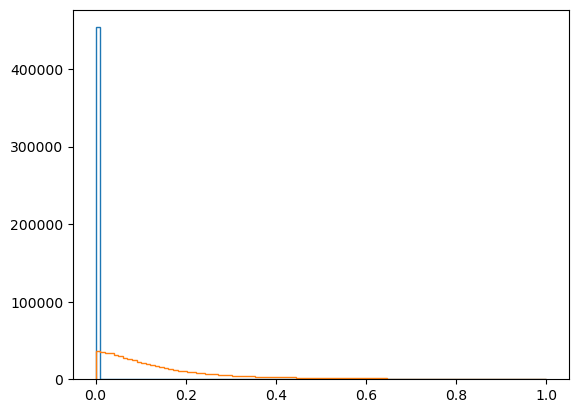

In [23]:
_, ax = plt.subplots()
bins = np.linspace(0, 1, 100)
ax.hist(X['avgdpdtolclosure24_3658938P_0'], bins=bins, histtype='step')
ax.hist(X_preds['avgdpdtolclosure24_3658938P_0'], bins=bins, histtype='step')
plt.show()

In [24]:
display(mask_truth)
display(mask_preds)

,year_first_birth_259D_1,pmtnum_254L_0,price_1097A_0,mobilephncnt_593L_0,median_dpdmaxdateyear_596T_1,isbidproduct_1095L_0,median_maxdpdtolerance_577P_1,avgdpdtolclosure24_3658938P_0,max_totalamount_6A_1,year_first_empl_employedfrom_271D_1,...,first_registaddr_district_1083M_1,lastapprcommoditycat_1041M_0,lastrejectreasonclient_4145040M_0,previouscontdistrict_112M_0,first_language1_981M_1,disbursementtype_67L_0,first_education_1138M_1,first_district_544M_1,first_rejectreasonclient_4145042M_1,first_contractst_964M_1
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478660,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
1478661,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1478662,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1478663,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


,year_first_birth_259D_1,pmtnum_254L_0,price_1097A_0,mobilephncnt_593L_0,median_dpdmaxdateyear_596T_1,isbidproduct_1095L_0,median_maxdpdtolerance_577P_1,avgdpdtolclosure24_3658938P_0,max_totalamount_6A_1,year_first_empl_employedfrom_271D_1,...,first_registaddr_district_1083M_1,lastapprcommoditycat_1041M_0,lastrejectreasonclient_4145040M_0,previouscontdistrict_112M_0,first_language1_981M_1,disbursementtype_67L_0,first_education_1138M_1,first_district_544M_1,first_rejectreasonclient_4145042M_1,first_contractst_964M_1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478660,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1478661,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
1478662,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1478663,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [25]:
corr_coef = []
for col in X.columns:
    corr_coef.append((col, np.corrcoef(X[col], X_preds[col])[0, 1]))
corr_coef = pd.DataFrame(corr_coef, columns=['Variable', 'correlation coefficient'])
corr_coef.sort_values('correlation coefficient', inplace=True)
corr_coef.set_index('Variable', inplace=True)
display(corr_coef)

,correlation coefficient
Variable,
day_responsedate_1012D_0,-0.177831
day_first_lastupdate_1112D_1,-0.103133
day_first_refreshdate_3813885D_1,-0.055845
day_first_numberofoverdueinstlmaxdat_641D_1,0.007456
median_overdueamountmax_35A_1,0.016993
...,...
first_registaddr_district_1083M_1,0.898996
first_contaddr_district_15M_1,0.899927
first_district_544M_1,0.911341


<Axes: ylabel='Variable'>

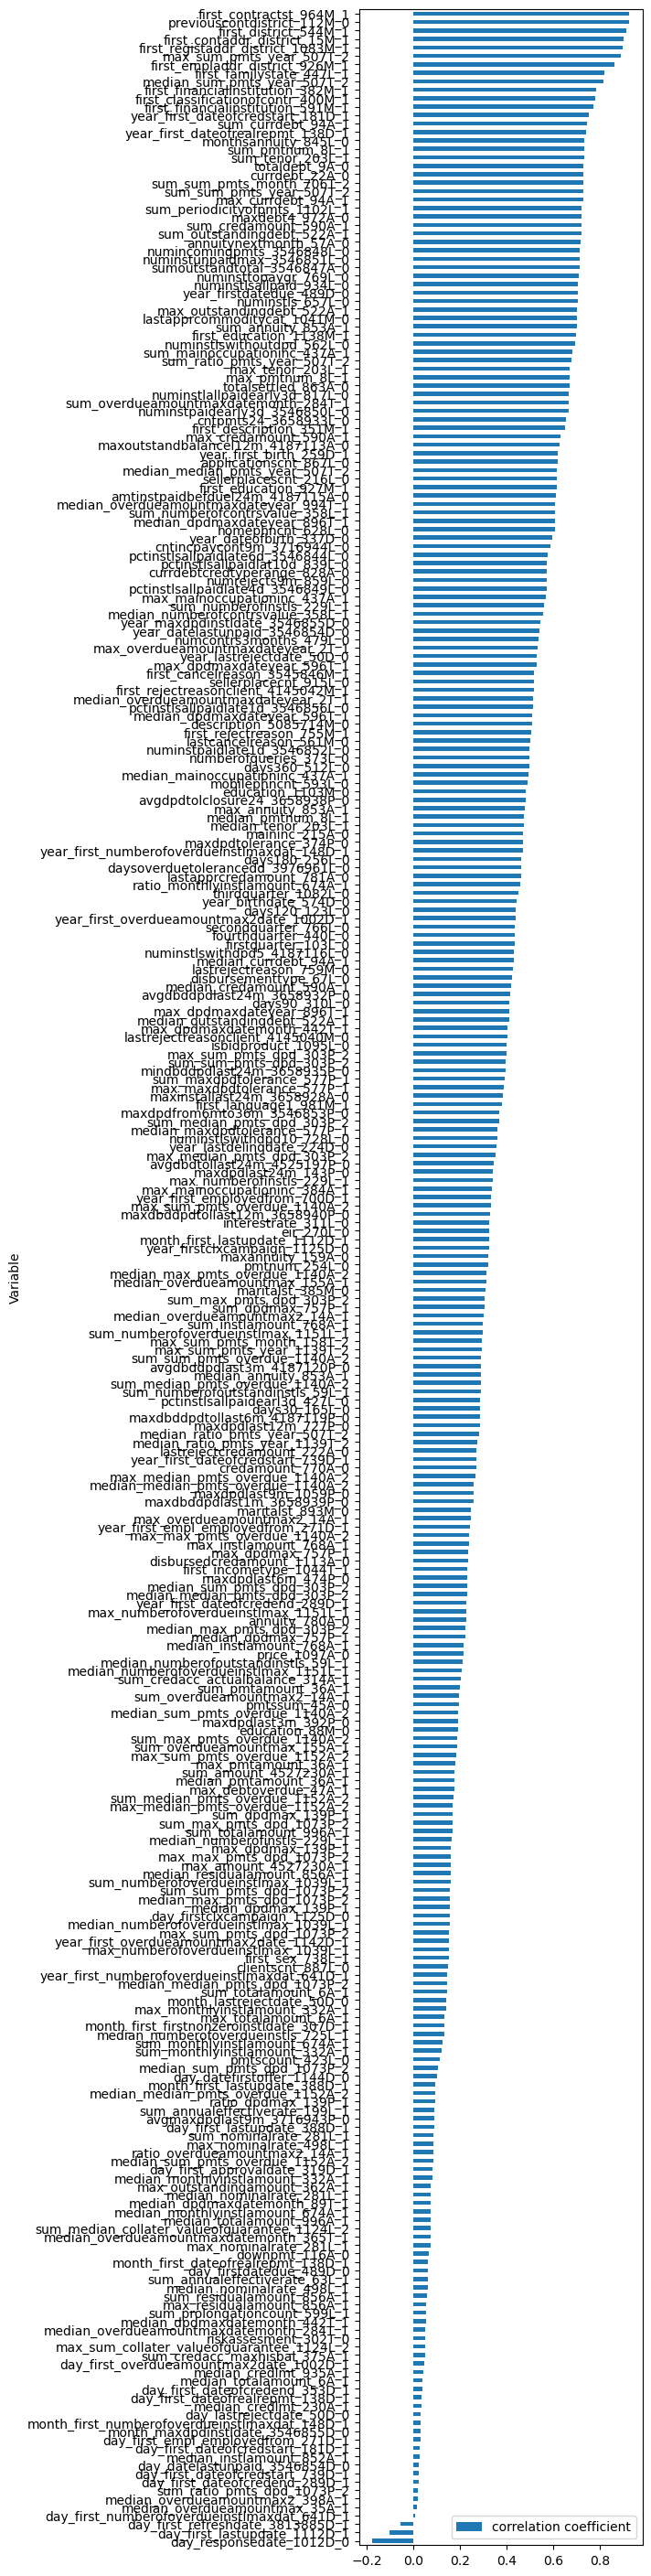

In [26]:
corr_coef.plot.barh(figsize=(4, 36))

In [27]:
corr_coef = []
for col in mask_truth.columns:
    corr_coef.append((col, np.corrcoef(mask_truth[col], mask_preds[col])[0, 1]))
corr_coef = pd.DataFrame(corr_coef, columns=['Variable', 'correlation coefficient'])
corr_coef.sort_values('correlation coefficient', inplace=True)
corr_coef.set_index('Variable', inplace=True)
display(corr_coef)

/home/ss/miniconda3/envs/home_credit/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ss/miniconda3/envs/home_credit/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,correlation coefficient
Variable,
year_first_numberofoverdueinstlmaxdat_641D_1,-0.000977
median_residualamount_856A_1,-0.000840
sum_prolongationcount_599L_1,-0.000646
day_responsedate_1012D_0,-0.000603
max_instlamount_768A_1,-0.000595
...,...
first_description_351M_1,0.950409
first_rejectreasonclient_4145042M_1,0.958025
maritalst_893M_0,0.962700


<Axes: ylabel='Variable'>

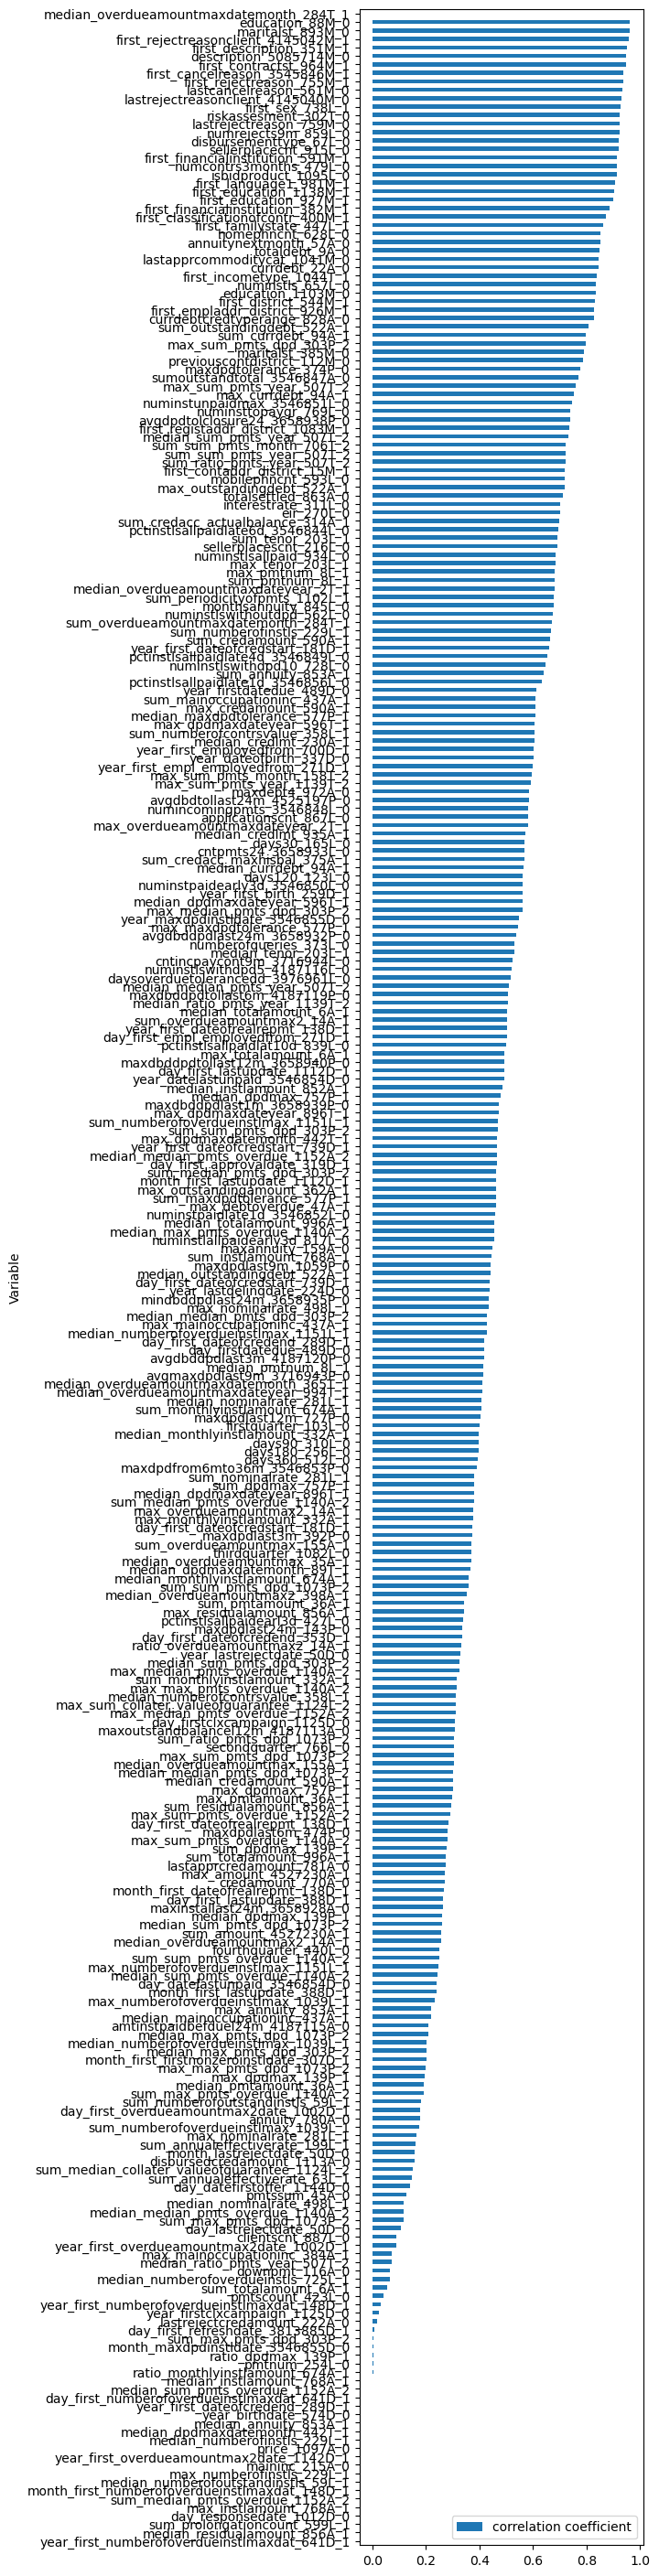

: 

In [28]:
corr_coef.plot.barh(figsize=(4, 36))